In [3]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [6]:
DATA_DIR = "/Users/kliakhnovich/DEV/MADE/rec_sys_2023/recsys-itmo-spring-2023/botify/data/"

In [7]:
data = pd.read_json(DATA_DIR + "input.json", lines=True).drop_duplicates(subset=["user", "track"])

In [8]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [9]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [10]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [11]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(11671, 4397)

In [12]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [13]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [14]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2023-04-13 00:14:44,862] A new study created in memory with name: no-name-7333ec9d-9edc-4ec5-863a-28421e256649
[I 2023-04-13 00:14:45,130] Trial 0 finished with value: 0.004461942706257105 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.0001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.004461942706257105.
[I 2023-04-13 00:14:45,368] Trial 1 finished with value: 0.016097988933324814 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.016097988933324814.
[I 2023-04-13 00:14:45,581] Trial 2 finished with value: 0.05188101902604103 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 10, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 2 with value: 0.05188101902604103.
[I 2023-04-13 00:14:45,892] Trial 3 finished with value: 0.0492563471198082 and parameter

In [16]:
best_params

{'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 50,
 'user_alpha': 0.0001,
 'item_alpha': 0.0}

In [17]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.05030621588230133 +/- 0.004959470603356963
1:	0.05074365809559822 +/- 0.004977086398151248
2:	0.05284339562058449 +/- 0.0051888266706794275
3:	0.054243218153715134 +/- 0.0053034552472506
4:	0.0587051659822464 +/- 0.005582978945359966
5:	0.06036745384335518 +/- 0.005698743091274103
6:	0.06299212574958801 +/- 0.005828928406322361
7:	0.0673665776848793 +/- 0.006053867890711457
8:	0.06999125331640244 +/- 0.006242454470177508
9:	0.07226597517728806 +/- 0.00642143168822364
10:	0.07419072836637497 +/- 0.006597263521729844
11:	0.07594051212072372 +/- 0.006694629198201749
12:	0.07707787305116653 +/- 0.006767011053309454
13:	0.0772528424859047 +/- 0.006842511512698713
14:	0.07856518030166626 +/- 0.00685460279935434
15:	0.07874015718698502 +/- 0.006890689197512605
16:	0.07909011840820312 +/- 0.006894290278384537
17:	0.07926508784294128 +/- 0.006964017432396056
18:	0.07909011840820312 +/- 0.006958028157192722
19:	0.07935258001089096 +/- 0.006979665310139541
20:	0.0791776105761528 +/- 0.006969

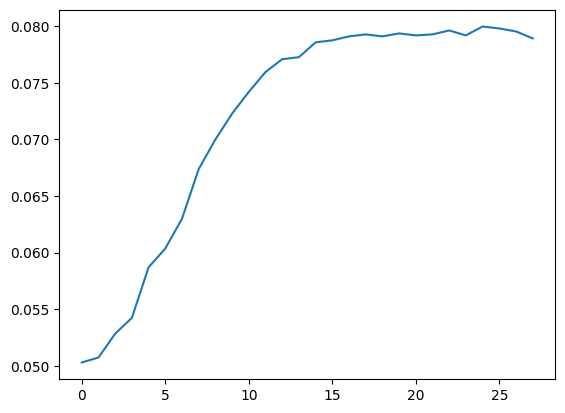

In [18]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [23]:
biases, embeddings = model.get_item_representations()

In [24]:
model.item_biases *= 0.0

In [25]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [26]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [27]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [28]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [30]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████| 1526/1526 [00:00<00:00, 6626.66it/s]
